In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.animation import FuncAnimation
from scipy.stats import uniform
from observision_models import NormalObservation
from IPython.display import HTML

# Simulate ball throwing and generate Observations

In [2]:
from ball_throwing_simulator import BallThrowingSimulator

(4, 1)
(61, 4, 1) (61, 2, 1)


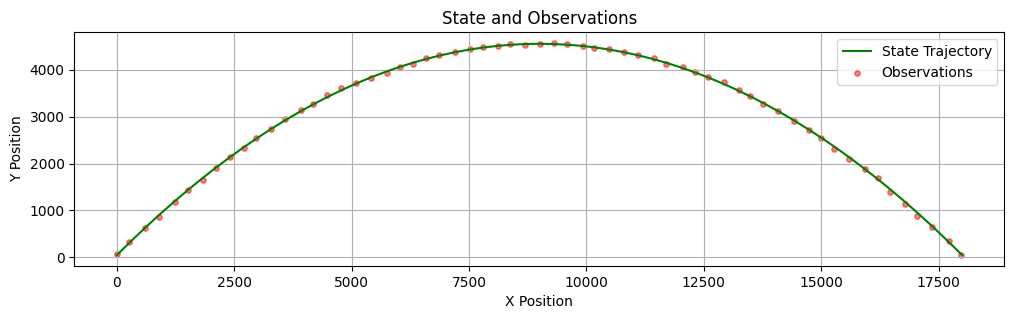

In [8]:
ball_num = 1
init_state = np.array([[0], [50], [300], [300]])  # Initial state: [x, y, vx, vy]
simulator = BallThrowingSimulator(delta_t=1, init_state=init_state, ball_num=ball_num, observation_variance=[10, 10])
# Simulate the motion and observations
states, observations = simulator.simulate(time=60)
print(states.shape, observations.shape)
# Show the simulated states and observations
fig, ax = plt.subplots(figsize=(12, 12))
plot_observations(ax, states, observations)

# Initilaize
## State
$$[X, Y, V_x, V_y]^T$$

## Uniform Random Particle Sets
$$X, Y \in [0, 3000]$$
$$V_x, V_y \in [0, 200]$$

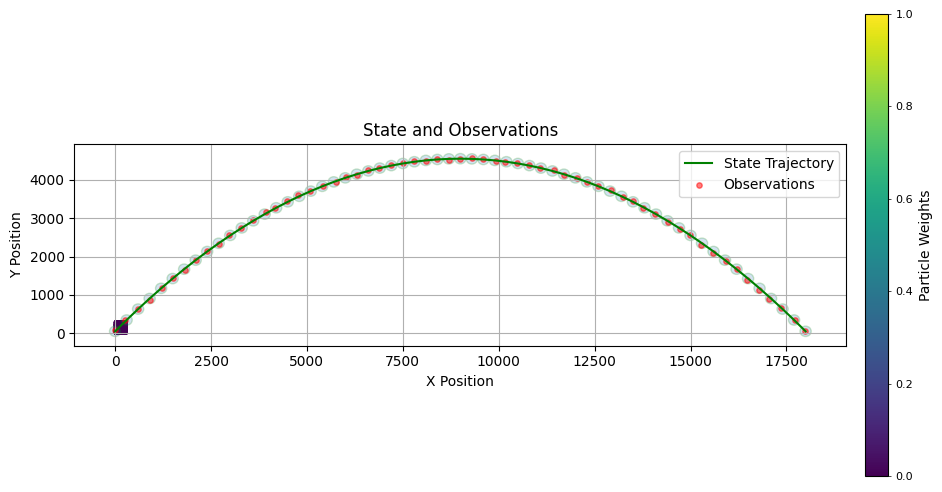

In [9]:
from partickle_filter import ParticleFilter
# initialize 1000 random particles
pf = ParticleFilter(10000)

init_particles, init_weights = pf.snaps[0]

# show initial particles
fig, ax = plt.subplots(figsize=(12, 12))
# ax.set_xlim(0, 3000)
# ax.set_ylim(0, 3000)
ax.set_title('Initial Particles')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plot_particles(ax, init_particles, init_weights)
plot_observations(ax, states, observations, NormalObservation.R)
plt.show()

Neff:9999.999999999998
weighs max:0.0001, min:0.0001, mean:0.00010000000000000005
loglikelihood max:-14.085052576714043, min-8872.169420745606, mean:-2846.770016125273
Neff:1.5642018351473908
weighs max:0.7653813867073692, min:0.0, mean:0.0001
loglikelihood max:-23.216546802061497, min-114.61989468271986, mean:-59.57320881628804
Neff:2.618365100827885
weighs max:0.5600985447011805, min:1.1279629435233235e-40, mean:9.999999999999999e-05
loglikelihood max:-126.53186751290238, min-383.3132616173945, mean:-233.66390109535055
Neff:1.1709653152978268
weighs max:0.9211022170356841, min:2.7897501693656235e-112, mean:0.00010000000000000002
loglikelihood max:-285.345139194899, min-604.4732094982202, mean:-452.59593771916616
Neff:1.2791300840927713
weighs max:0.8812678473827438, min:2.2363922172728716e-139, mean:0.0001
loglikelihood max:-454.51748415670187, min-840.3210793129718, mean:-611.5940205219773
Neff:1.000000173055375
weighs max:0.9999999134723202, min:2.803028332921467e-168, mean:0.0001


MovieWriter imagemagick unavailable; using Pillow instead.


Neff:9999.999999999998
weighs max:0.0001, min:0.0001, mean:0.00010000000000000005
loglikelihood max:-10.030501191141179, min-8791.15754170384, mean:-2848.3387020024575
Neff:1.0051264074554669
weighs max:0.9974447569833967, min:0.0, mean:0.00010000000000000002
loglikelihood max:-23.38483616384405, min-120.88238749343067, mean:-63.93885915373154
Neff:1.1086549589697559
weighs max:0.9492043582473476, min:4.3123220003375185e-43, mean:9.999999999999999e-05
loglikelihood max:-131.97400573826314, min-365.3852672285887, mean:-208.1230368058193
Neff:1.7179787801723188
weighs max:0.7321690903598783, min:3.128877146742159e-102, mean:9.999999999999999e-05
loglikelihood max:-257.2995829990295, min-586.7731179205485, mean:-413.7288699042158
Neff:1.0000003949051037
weighs max:0.9999998025474882, min:8.15570981026849e-144, mean:0.0001
loglikelihood max:-569.5739427586104, min-925.7802557139772, mean:-740.14375680289
Neff:1.0309422232934946
weighs max:0.9847618416352149, min:1.9719462644088092e-155, me

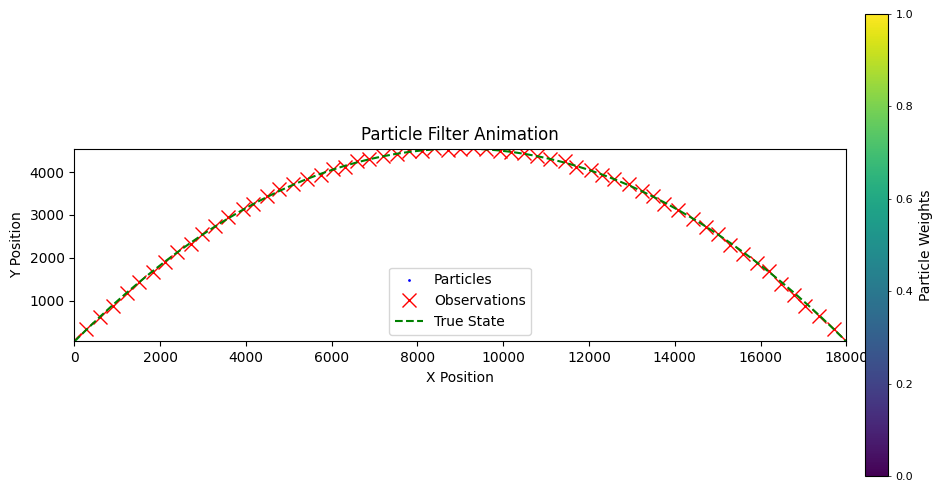

In [10]:
# 1. 初始化图表
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title('Particle Filter Animation')
ax.set_xlim(0, np.max(states[:,0]))
ax.set_ylim(np.min(states[:,1]), np.max(states[:,1]))
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_aspect('equal', adjustable='box') # 保持坐标轴比例一致，避免椭圆变形


# 初始化用于动画的图元
# 散点图的集合 (Collection) 用于粒子，线条用于观测和真实状态
# 注意：plt.plot 返回的是一个列表，需要解包
probs_colormap = 'viridis'

particles_scatter = ax.scatter([], [], s=[], alpha=1, c='blue', label='Particles')

observations_plot, = ax.plot([], [], 'rx', markersize=10, label='Observations')
true_state_plot, = ax.plot([], [], 'g--', label='True State') # 如果有真实状态

sm = plt.cm.ScalarMappable(
        cmap=probs_colormap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.02)
cbar.set_label('Particle Weights')
# make colorbar smaller
cbar.ax.tick_params(labelsize=8, length=2, width=0.5)

# 添加图例
ax.legend()

# 2. 定义更新函数
def update(frame):
    global particles, weights # 声明使用全局变量
    
    # 在第一帧（frame=0）初始化粒子和权重
    if frame == 0:
        particles, weights = pf.particles, pf.weights
    else:
        # 更新粒子和权重
        # 确保 frame 没有超出 observations 的范围
        if frame -1 < observations.shape[0]: # frame -1 是因为 frame 从0开始，而observations[i]需要i>=0
            particles, weights = pf.update(particles, weights, observations[frame-1,:])

    # 更新粒子的数据
    particles_scatter.set_offsets(particles)
    particles_scatter.set_color(colormaps.get_cmap(probs_colormap)(weights))
    particles_scatter.set_sizes(np.ones(pf.N)*5)

    # 更新观测数据，只显示到当前帧为止的观测
    current_observations = observations[:min(frame + 1, observations.shape[0])]
    observations_plot.set_data(current_observations[:, 0], current_observations[:, 1])

    # 更新真实状态数据（如果存在）
    if states is not None:
        current_states = states[:min(frame + 1, states.shape[0])]
        true_state_plot.set_data(current_states[:, 0], current_states[:, 1])
    
    plt.savefig(f"outputs/frame_{frame:03.0f}.png")

    # 返回所有需要更新的图元
    return particles_scatter, observations_plot, true_state_plot

# 3. 创建 FuncAnimation 对象
# frames: 动画的总帧数，这里是观测的数量 + 1 (为了包含初始帧)
# interval: 每帧之间的毫秒数
# blit: True 可以优化性能，只重绘变化的图元
ani = FuncAnimation(fig, update, frames=observations.shape[0] + 1, interval=100, blit=True)

# 4. 显示动画
# plt.show()
HTML(ani.to_jshtml())

ani.save('particle_filter_animation.gif', writer='imagemagick', fps=10)